In [1]:
import pickle
import numpy as np

tsdir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
demofile = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/demographics.pkl'
tsdict = dict()

for task in ['nback']:
    item = pickle.load(open(f'{tsdir}/PNC_SPM_{task}_good_filt.pkl', 'rb'))
    tsdict[task] = item
    
rest = []
age = []

demo = pickle.load(open(demofile, 'rb'))

for sub in demo['age_at_cnb']:
    try:
        tsr = tsdict['nback'][sub]
        a = demo['age_at_cnb'][sub]
    except:
        continue
    rest.append(tsr)
    age.append(a)

rest = np.stack(rest)
age = np.array(age)

print([a.shape for a in [rest, age]])

[(1456, 264, 231), (1456,)]


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(xhat, xt):
    return torch.mean((xt-xhat)**2)**0.5

def dynamic(ts):
    a,b = torch.triu_indices(264,264,1)
    p = torch.einsum('at,bt->tab', ts, ts)
    return p[:,a,b] 

class SingleSubDict(nn.Module):
    def __init__(self, nd, nt, rank):
        super(SingleSubDict, self).__init__()
        self.A = nn.Parameter(1e-2*torch.randn(nd, 264, rank).float().cuda())
        self.w = nn.Parameter(torch.randn(nd, nt).float().cuda())
        
    def entries(self):
        A = torch.einsum('dar,dbr->dab', self.A, self.A)
        return A
    
    def forward(self):
        A = self.entries()
        p = torch.einsum('dab,dt->tab', A, self.w)
        a,b = torch.triu_indices(264,264,1)
        return p[:,a,b]
    
ts_t = torch.from_numpy(rest/np.linalg.norm(rest, ord=2, axis=-1, keepdims=True)).float().cuda()

As = []
ws = []

for i in range(1): #ts_t.shape[0]):
    ssd = SingleSubDict(10, ts_t.shape[-1], 1)
    optim = torch.optim.Adam(ssd.parameters(), lr=1e-1, weight_decay=0)

    nepochs = 300
    pperiod = 20

    x = dynamic(ts_t[i])

    for e in range(nepochs):
        optim.zero_grad()
        xhat = ssd()
        loss = rmse(xhat, x)
#         l1 = torch.mean(torch.abs(torch.linalg.norm(ssd.w, dim=0, ord=1)-1))
#         (loss+l1).backward()
        loss.backward()
        optim.step()
        if e % pperiod == 0 or e == nepochs-1:
            print(f'{e} {float(loss)} {float(l1)}')
            
    As.append(ssd.A.detach().cpu().numpy().squeeze())
    ws.append(ssd.w.detach().cpu().numpy())
    
    if i % 10 == 0:
        print(f'Done {i}')
        
print('Complete')

0 0.0048911962658166885 0.3909527659416199
20 0.005273413844406605 0.3909527659416199
40 0.004785210359841585 0.3909527659416199
60 0.004516332410275936 0.3909527659416199
80 0.004344453103840351 0.3909527659416199
100 0.004124904051423073 0.3909527659416199
120 0.00404092064127326 0.3909527659416199
140 0.00402133259922266 0.3909527659416199
160 0.0039964960888028145 0.3909527659416199
180 0.003983916714787483 0.3909527659416199
200 0.003981406334787607 0.3909527659416199
220 0.003979138098657131 0.3909527659416199
240 0.003974935971200466 0.3909527659416199
260 0.003972419537603855 0.3909527659416199
280 0.00397199671715498 0.3909527659416199
299 0.00397192407399416 0.3909527659416199
Done 0
Complete


In [293]:
# Save

fname = '/home/anton/Documents/Tulane/Research/Work/DynamicDict/nback10-1-l1.pkl'
dct = dict(A=As, w=ws)

pickle.dump(dct, open(fname, 'wb'))

print('Done')

Done


In [267]:
a,b = np.triu_indices(264,1)
Amat = []
for i in range(len(As)):
    m = np.einsum('dar,dbr->dab', As[i], As[i])
    Amat.append(m[:,a,b])
    
Asflat = np.abs(np.concatenate(Amat))
print(Asflat.shape)

(27740, 34716)


In [288]:
Asflat = np.abs(np.concatenate(As))
print(Asflat.shape)

(14560, 264)


In [255]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [291]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=64, n_init='auto').fit(Asflat)
z = km.cluster_centers_
print(z.shape)

(64, 264)


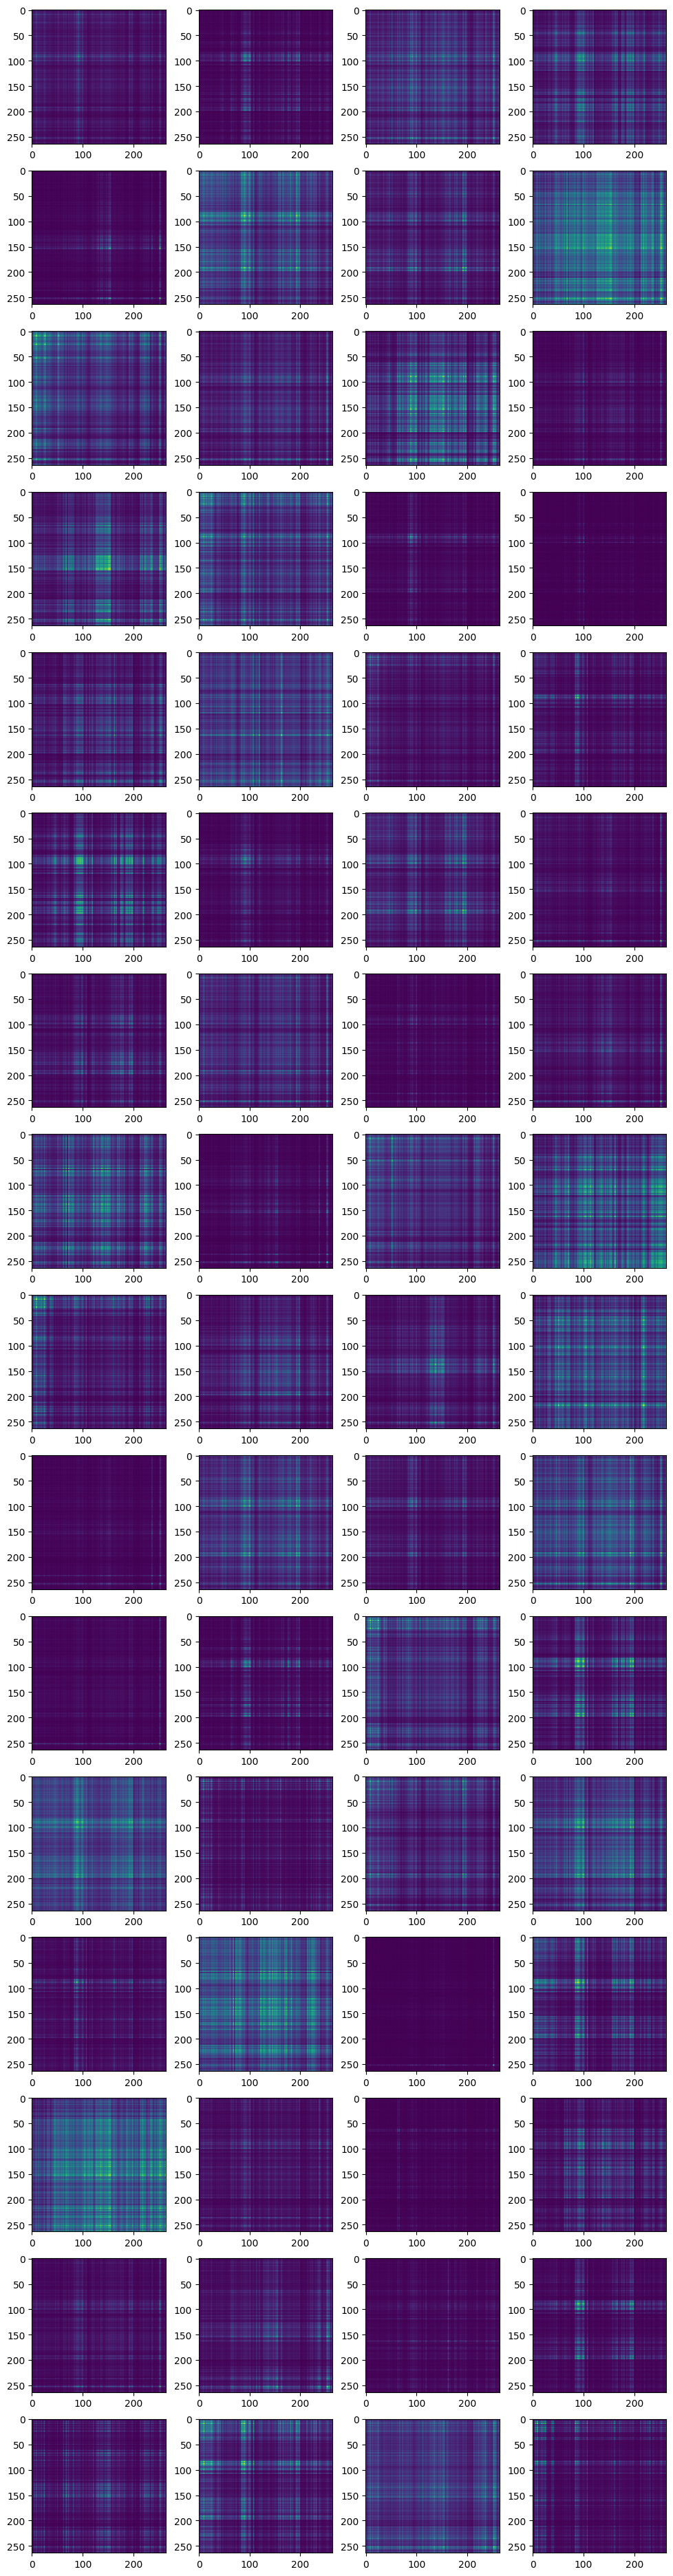

In [292]:
fig, ax = plt.subplots(16,4,figsize=(12,48))

for i in range(16):
    for j in range(4):
        z0 = np.einsum('a,b->ab', z[i*4+j], z[i*4+j])
        ax[i,j].imshow(remap(z0))

fig.show()

(10, 264, 264)


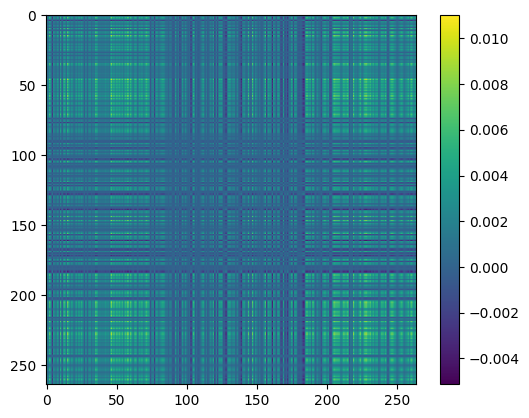

In [50]:
import matplotlib.pyplot as plt

def vec2mat(x):
    X = np.zeros((264,264))
    a,b = np.triu_indices(264,1)
    X[a,b] = x
    X[b,a] = x
    return X

a = ssd.entries().detach().cpu().numpy()
print(a.shape)

# plt.imshow(vec2mat(x.detach().cpu().numpy()[0]))
plt.imshow(a[6])
plt.colorbar()
plt.show()

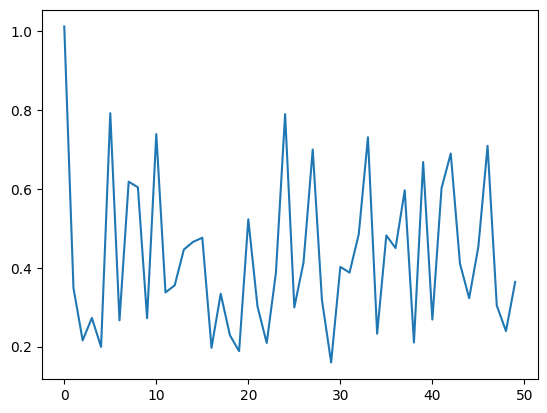

In [223]:
w = np.abs(ssd.w.detach().cpu().numpy())
ww = np.mean(w, axis=1)

plt.plot(ww)
plt.show()